# Script to analyze whole SNP-data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

In [2]:
### Load the Data
print("Loading...")

#data_path = "Data/CB108.impute.geno.gz"
#df = pd.read_csv(data_path, compression='gzip', sep="\t")

# Data Version 1
data_path = "Data0.1/CB108_beagle_Het15.geno.zip" 
df = pd.read_csv(data_path, compression='zip', sep="\t")

print("Finished loading. Markers: %i" % len(df))
print("Nr. of Individuals: %i" % (df.shape[1]-4))
df.head(2)

Loading...


IOError: [Errno 2] No such file or directory: 'Data0.1/CB108_beagle_Het15.geno.zip'

## Do some preliminary Analysis:

In [3]:
# Extract the SNP Matrix:
snp_df = df.iloc[:,4:]
snp_df.head(3)

,CB001,CB047,RP290,CB061,CB063,CB068,CB073,CB074,CB075,CB077,...,CB412,CB414,CB416,CB417,CB418,CB475,CB477,CB478,CB479,CB480
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


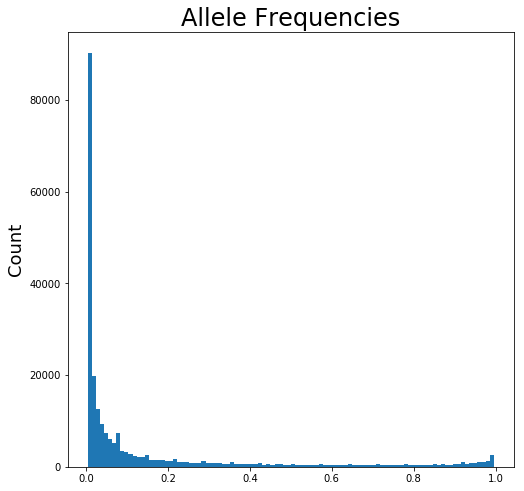

SNPs of frequency 0.2-0.8: 36161 out of 235276


In [4]:
# Plot allele frequency spectrum:
p_means = np.mean(snp_df/2.0,axis=1)

plt.figure(figsize=(8,8))
plt.hist(p_means,bins=100)
plt.title("Allele Frequencies", fontsize=24)
plt.ylabel("Count", fontsize=18)
plt.show()

p_means_intermediate = p_means[(0.2<p_means.values) & (p_means.values<0.8)]
print("SNPs of frequency 0.2-0.8: %i out of %i" % (len(p_means_intermediate),len(p_means)))

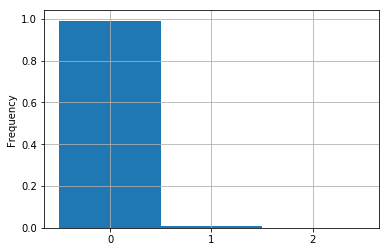

In [5]:
# Look into heterozygosity:

# Look into empirical Heterozygosity:
# 1) Calculate Empirical Heterozygosity:
htz = np.mean(snp_df==1,axis=1)     # Calculate the empirical heterozygosity
exp_htz = 2.0 * p_means * (1-p_means)     # Calculate the expected heterozygosity

# The Most Heterozygous Marker:
snp_df.iloc[121259,:]
plt.figure()
plt.hist(snp_df.iloc[121259,:], bins=[-0.5,0.5,1.5,2.5],normed="True")
plt.xticks([0,1,2])
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

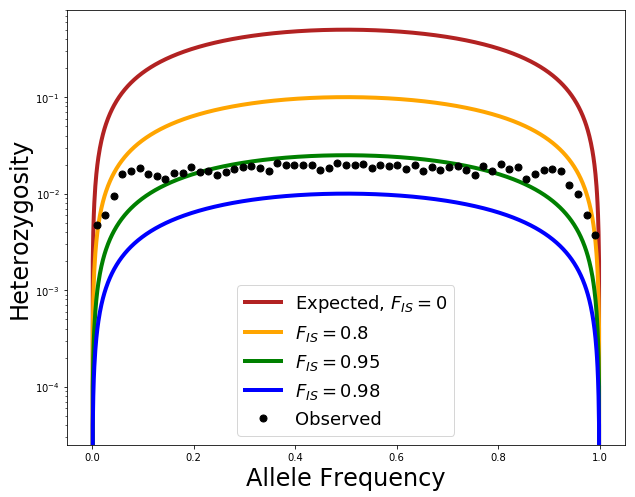

In [54]:
# Plot Heterozygosities:

def plot_hts(snp_df):
    # Calculate Empirical Heterozygosity:
    htz = np.mean(snp_df==1,axis=1)     # Calculate the empirical heterozygosity
    p_means = np.mean(snp_df/2.0,axis=1)

    x_array = np.linspace(0,1,1000) # For the Plot
    y = 2*x_array*(1-x_array) # Expected Heterozygosity
    y_01 = 2*x_array*(1-x_array) * 0.2 # For F_IS=0.8
    y_02 = 2*x_array*(1-x_array) * 0.05 # For F_IS=0.94
    y_03 = 2*x_array*(1-x_array) * 0.02 # For F_IS=0.98

    # Calculate the bin values:
    bins = np.linspace(0,1,60) # Make 100 Bins.
    mean_hzs, bin_edges, _ = binned_statistic(p_means, htz, statistic='mean', bins=bins)
    #nr_markers, _ = np.histogram(p_means, bins=bins, normed=True)
    
    means = (bin_edges[1:] + bin_edges[:-1])/2.0


    plt.figure(figsize=(10,8))
    plt.plot(x_array, y, linewidth=4, label=r"Expected, $F_{IS}=0$", color="FireBrick")
    plt.plot(x_array, y_01, linewidth=4, label=r"$F_{IS}=0.8$", color="Orange")
    plt.plot(x_array, y_02, linewidth=4, label=r"$F_{IS}=0.95$", color="Green")
    plt.plot(x_array, y_03, linewidth=4, label=r"$F_{IS}=0.98$", color="Blue")

    # Plot The Observed Values
    plt.plot(means, mean_hzs, "o", color="Black", label="Observed", markersize=7)
    #plt.plot(means, nr_markers/60.0, "ro-", label="Nr Markers")
    plt.ylabel("Heterozygosity", fontsize=24)
    plt.xlabel("Allele Frequency", fontsize=24)
    plt.yscale("log")
    plt.legend(fontsize=18)
    plt.show()

plot_hts(snp_df)

## Redo the $F_{\text{IS}}$ plot - Remove markers that are correlated to Geography!

In [8]:
# Redo the Plot - But remove markers correlated with Geography! (To take Wahlund Effect into Account)

# Calculate Correlations
## Asssign Individuals according to their position:
coordinate_path = "./Data/CB108.coordinate.txt"  # Load coordinate Data
coords = pd.read_csv(coordinate_path, sep="\t")

inds = list(df)[4:]
l = len(inds) # Nr of Inds
k = df.shape[0] # Nr of rows

lats, longs = np.zeros(l), np.zeros(l)

for i in xrange(l):
    s = inds[i]
    match=coords[coords["ID"].str.match(s)]  # Find all matching Scaffolds
    assert(len(match)==1)
    
    lats[i], longs[i] = match.Latitude, match.Longitude

# Make Containers for the Correlation Values:
lat_corr=np.zeros(k)
lon_corr=np.zeros(k)

# Calculate correlations with Latitude and Longitude
for i in xrange(k):
    if i % 1000 == 0:
        print("Doing Calculation %i" % i)
    genotypes = df.iloc[i,4:].astype("int")
    lat_corr[i] = np.corrcoef(genotypes,lats)[0,1]
    lon_corr[i] = np.corrcoef(genotypes,longs)[0,1]

# Do the plot with and without removing the markers

 Doing Calculation 0
Doing Calculation 1000
Doing Calculation 2000
Doing Calculation 3000
Doing Calculation 4000
Doing Calculation 5000
Doing Calculation 6000
Doing Calculation 7000
Doing Calculation 8000
Doing Calculation 9000
Doing Calculation 10000
Doing Calculation 11000
Doing Calculation 12000
Doing Calculation 13000
Doing Calculation 14000
Doing Calculation 15000
Doing Calculation 16000
Doing Calculation 17000
Doing Calculation 18000
Doing Calculation 19000
Doing Calculation 20000
Doing Calculation 21000
Doing Calculation 22000
Doing Calculation 23000
Doing Calculation 24000
Doing Calculation 25000
Doing Calculation 26000
Doing Calculation 27000
Doing Calculation 28000
Doing Calculation 29000
Doing Calculation 30000
Doing Calculation 31000
Doing Calculation 32000
Doing Calculation 33000
Doing Calculation 34000
Doing Calculation 35000
Doing Calculation 36000
Doing Calculation 37000
Doing Calculation 38000
Doing Calculation 39000
Doing Calculation 40000
Doing Calculation 41000
Doin

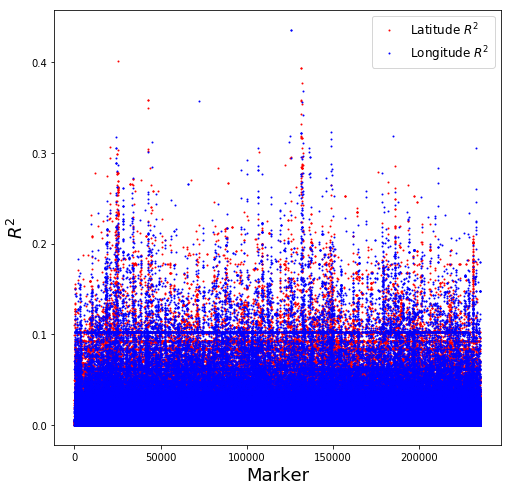

In [25]:
plt.figure(figsize=(8,8))
plt.plot(lat_corr**2, "ro", label=r"Latitude $R^2$", markersize=1)
plt.plot(lon_corr**2, "bo", label=r"Longitude $R^2$", markersize=1)
plt.xlabel("Marker", fontsize=18)
plt.ylabel(r"$R^2$", fontsize=18)
plt.legend(fontsize=12)
plt.show()

(99906, 108)


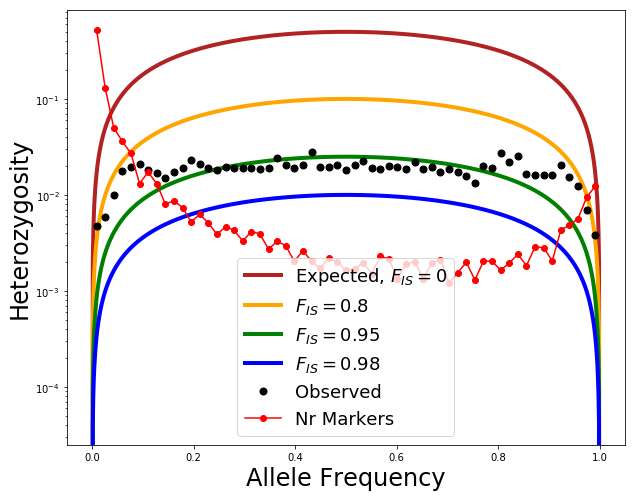

In [53]:
# Do the actual Plot:
r2_cutoff = 0.01
snp_df_clean = snp_df[(lat_corr**2 < r2_cutoff) & (lon_corr**2 < r2_cutoff)]
print(snp_df_clean.shape)

plot_hts(snp_df_clean)

In [241]:
np.max(df.iloc[:,4:-2])

CB001    2
CB047    2
RP290    2
CB061    2
CB063    2
CB068    2
CB073    2
CB074    2
CB075    2
CB077    2
CB078    2
CB081    2
CB082    2
CB083    2
CB085    2
CB086    2
CB087    2
CB088    2
CB090    2
CB092    2
CB093    2
CB100    2
CB102    2
CB103    2
CB151    2
CB154    2
CB156    2
CB158    2
CB159    2
CB160    2
        ..
CB373    2
CB374    2
CB375    2
CB376    2
CB377    2
CB381    2
CB382    2
CB383    2
CB385    2
CB388    2
CB391    2
CB392    2
CB394    2
CB399    2
CB401    2
CB405    2
CB406    2
CB407    2
CB408    2
CB410    2
CB412    2
CB414    2
CB416    2
CB417    2
CB418    2
CB475    2
CB477    2
CB478    2
CB479    2
CB480    2
dtype: int64

## Plot the distribution of SNPs on a Chromosome Map
This helps to see whether we can in principle detect IBD blocks

In [90]:
# Load the Linkage Map of all Markers:
print("Loading Linkage Map...")
data_path = "Data0.1/7LGs_0916.fmap" 
lm = pd.read_csv(data_path, sep="\t")
print("Nr. Linkage Map Entries: %i" % lm.shape[0])

s = lm["start"] > lm["end"]
print("Swapped Starts and Ends: %i" % np.sum(s))

print("Swapping Values...")
lm.loc[s, ['start','end']] = lm.loc[s, ['end','start']].values
print("Swapping Complete!!")

Loading Linkage Map...
Nr. Linkage Map Entries: 9273
Swapped Starts and Ends: 4657
Swapping Values...
Swapping Complete!!


In [141]:
def locate_lm(sca, pos, lm):
    '''Locate scaffold and position on lm.
    Return Chromosome Number (LG) and Position
    
    Scaffold: String
    Pos: Integer'''
    sub=lm[lm["sca"].str.match(sca)]  # Find all matching Scaffolds
    match=sub[(sub["start"]<= pos) & (sub["end"]>=pos)]    # Find all matching Positions in Scaffold
    
    if len(match)!=1: # Sanity Check
        print(sca)
        print(pos)
        print("Length of Match: %i" %len(match))
        #raise RuntimeWarning("Unclear Match")
        return (0, 0)
        
        
    cm = match["CM"]
    chrom = match["#LG"]
    
    return (chrom, cm)
        
    
k = df.shape[0] # Nr of Markers

cms = np.zeros(k)
chroms = np.zeros(k)

print("Detecting exact Positions...")
# Iterate over all Markers
for i in xrange(k):
    if i % 1000 == 0:
        print(i)
    sca=df["#CHROM"].iloc[i]  # Extract Scaffold
    pos=df["POS"].iloc[i]     # Extract Position
    
    chrom, cm = locate_lm(sca, pos, lm)
    cms[i]=cm
    chroms[i]=chrom

Detecting exact Positions...
0
1000
2000
3000
4000
5000
6000
7000
Scaffold10094
30
Length of Match: 0
Scaffold10094
43
Length of Match: 0
Scaffold10094
56
Length of Match: 0
Scaffold10094
66
Length of Match: 0
Scaffold10094
87
Length of Match: 0
Scaffold10094
99
Length of Match: 0
Scaffold10094
194
Length of Match: 0
Scaffold10094
233
Length of Match: 0
Scaffold10094
238
Length of Match: 0
Scaffold10094
270
Length of Match: 0
Scaffold10094
441
Length of Match: 0
Scaffold10094
583
Length of Match: 0
Scaffold10094
638
Length of Match: 0
Scaffold10094
653
Length of Match: 0
Scaffold10094
855
Length of Match: 0
Scaffold10094
875
Length of Match: 0
Scaffold10094
877
Length of Match: 0
Scaffold10094
900
Length of Match: 0
Scaffold10094
903
Length of Match: 0
Scaffold10094
922
Length of Match: 0
Scaffold10094
926
Length of Match: 0
Scaffold10132
92
Length of Match: 0
Scaffold10132
109
Length of Match: 0
Scaffold10132
117
Length of Match: 0
Scaffold10132
123
Length of Match: 0
Scaffold10132
13

In [147]:
# How many Loci could not be placed:

print("Nr of Loci that could not be placed: %i" % np.sum(chroms==0))
# Add the new columns:
#df["cm"]=cms
#df["chr"]=chroms
df.to_csv('Data_Clean/genotypes.gz', index=False, compression="gzip") # Save to new File

Nr of Loci that could not be placed: 10438


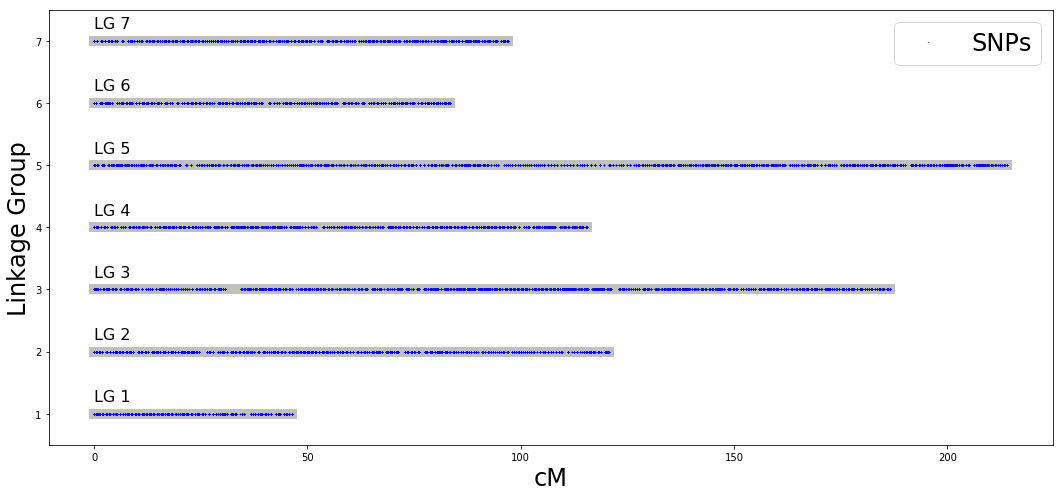

In [199]:
# Plot the Figure:
chr_nr = 7

mins=np.zeros(chr_nr)
maxs=np.zeros(chr_nr)

# Determine the Min Max for each Chromosome
for i in xrange(chr_nr):
    sub=df[df["chr"]==i+1] # Extract all matching chromosomes
    mins[i]=np.min(sub["cm"])
    maxs[i]=np.max(sub["cm"])


plt.figure(figsize=(18,8))
# Make the base lines
for i in xrange(chr_nr):
    plt.plot([0,maxs[i]], [i+1,i+1],linewidth=10, zorder=0, color="Silver")
    plt.text(0, i+1.2,"LG %i" % (i+1), fontsize=16)

# Plot the Markers:
plt.ylim([0.5,7.5])
plt.plot(df["cm"], df["chr"],"bo", markersize=0.3, label="SNPs", zorder=1)
plt.legend(fontsize=24)
plt.ylabel("Linkage Group", fontsize=24)
plt.xlabel("cM", fontsize=24)
plt.show()

In [191]:
# Calculate the SNP density in cM bins:
nr_snps = []
for i in xrange(1,8):
    sub=df[df["chr"]==i] # Extract all matching chromosomes
    nr_sn = []
    for j in xrange(0,int(maxs[i-1])):
        match = (sub["cm"]>=j) & (sub["cm"]<j+1)
        nr_sn.append(np.sum(match))
    nr_snps.append(nr_sn)

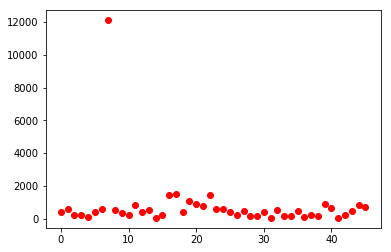

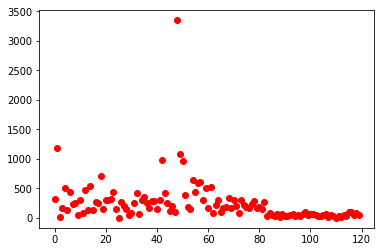

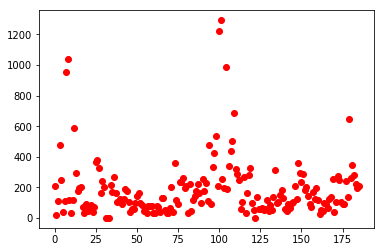

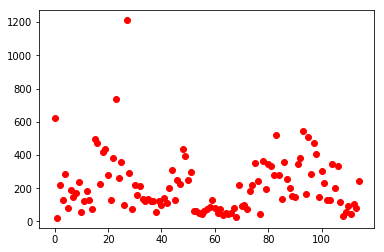

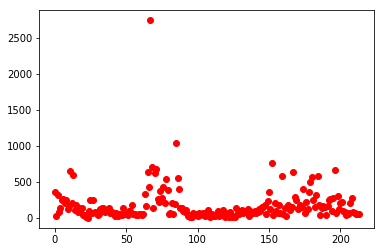

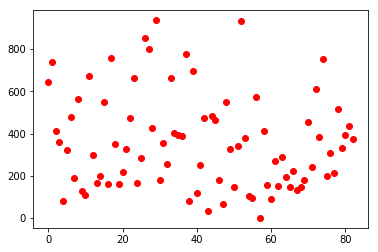

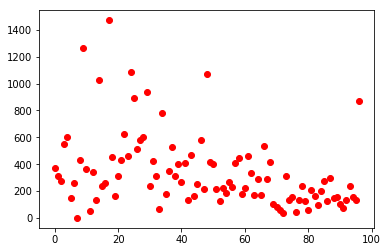

In [197]:
total_snps = np.sum(np.sum(ls) for ls in nr_snps)
for ls in nr_snps:
    plt.figure()
    plt.plot(ls, "ro")
    #plt.ylim([0,300])
    plt.show()

## Some Area 51 stuff:

In [198]:
print(np.sum(maxs))

863.338


In [270]:
np.corrcoef(np.array([0,1]),np.array([2,3]))[0,1]

0.99999999999999989

In [188]:
int(70.9)

70

In [ ]:
10